# Vehicles dataset creation


### Process Flow :

1. load file from Internet and create pickle snapshot in case dataset site off-line 
2. enrich dataset with push bike 'engine capacity' = 0 to avoid dropping data (defaults to -1)
    3. save enriched Vehicle data for downstream use
    4. reload preprocessed data and check details

### Input data

Vehicles data: from https://data.gov.uk/dataset/road-accidents-safety-data  
**Vehicles_FLM.csv**: from /Specs directory

### Output data

* 'Vehicles_2015.pickle': snapshot of Vehicles source data
* 'Vehicles.pickle' : **Vehicles dataset**
* saved data assessment plot (.png) snapshots

## Import external libraries

In [1]:
'''
RTA Vehicles required imports
'''
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
%matplotlib inline

## 'Import' RTAUtilities

In [2]:
'''
Provide output of csv and pickle formats for DataFrames
'''
def pick_and_csv(df, path, filename):
    import sys
    try:
        df.to_csv(path + filename + '.csv', index=False)
        df.to_pickle(path + filename + '.pickle')
    except IOError as (errno, strerror):
        print ('I/O error({0}): {1}'.format(errno, strerror))
        if errno == 13:
            print ('*** check to see if (someone has) file already open ***')
        elif errno == 2:
            print ('Directory parameter needs to be a valid directory')
    except:
        print ("Unexpected error:", sys.exc_info()[0])
        print ('*** is first parameter a DataFrame? ***')
        raise

## Load Vehicles data and create dataset

In [3]:
'''
Load Vehicle data - need to download Vehicle file to local Data diectory

'''
def push_bike_engine(row):
    if row['vehicle_type'] == 1: #change push bike default from -1 to 0 engine capacity
        return 0
    else:
        return row['engine_capacity']

start_time0 = time.time()

#load Vehicles file from url
url = 'http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Vehicles_2015.zip'
Vehicles = pd.read_csv(url, compression='zip', sep=',', quotechar='"', engine = 'python')

#Save Vehicle data as a csv and pickle file
_ = pick_and_csv(Vehicles, 'Data/', 'Vehicles_2015')

print ("Vehicles dataload from website: %s seconds " % (time.time() - start_time0))

Vehicles dataload from website: 38.9350001812 seconds 


In [4]:
start_time0 = time.time()

#load 'Field Load Map' specification
pfl = pd.read_csv('Specs/Vehicles_FLM_3.csv', low_memory=False)
pc_cols_rename = dict(pfl[['field_name','field_descriptor']].where(pfl['import']=='Y').dropna().values.tolist())
pc_cols_drop = pfl['field_name'].where(pfl['import']=='N').dropna().values.tolist()

#clean data
Vehicles.drop(pc_cols_drop, axis=1, inplace=True) # drop columns based on loaded 'FLM' spec
Vehicles.rename(columns=pc_cols_rename, inplace=True) #rename columns to lower case and no spaces based on 'FLM' spec
Vehicles.engine_capacity = Vehicles.apply(lambda x: push_bike_engine(x), axis=1) # push bike has 0 enngine capacity
Vehicles.astype(np.int, inplace=True, errors='ignore') # make all fields int64 - exception is Accident index.

#Save Vehicles format data as a csv and pickle file
_ = pick_and_csv(Vehicles, 'Data/', 'Vehicles')
    
print ("Vehicles dataset preparation: %s seconds " % (time.time() - start_time0))

Vehicles dataset preparation: 21.3760001659 seconds 


## Data assessment

In [5]:
'''
Reload RTA Vehicles dataframe to check properly saved and reloadable
'''
Vehicles = pd.read_pickle('Data/Vehicles.pickle')

In [6]:
Vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257845 entries, 0 to 257844
Data columns (total 23 columns):
accident_index                      257845 non-null object
vehicle_reference                   257845 non-null int64
vehicle_type                        257845 non-null int64
towing_and_articulation             257845 non-null int64
vehicle_manoeuvre                   257845 non-null int64
vehicle_location-restricted_lane    257845 non-null int64
junction_location                   257845 non-null int64
skidding_and_overturning            257845 non-null int64
hit_object_in_carriageway           257845 non-null int64
vehicle_leaving_carriageway         257845 non-null int64
hit_object_off_carriageway          257845 non-null int64
first_point_of_impact               257845 non-null int64
was_vehicle_left_hand_drive         257845 non-null int64
journey_purpose_of_driver           257845 non-null int64
sex_of_driver                       257845 non-null int64
age_of_driver     

In [7]:
Vehicles.head(2)

,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location-restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,vehicle_imd_decile
0,201506E098757,2,9,0,18,0,8,0,0,0,...,6,1,45,7,1794,1,11,-1,1,-1
1,201506E098766,1,9,0,9,0,8,0,0,0,...,6,2,25,5,1582,2,1,-1,-1,-1


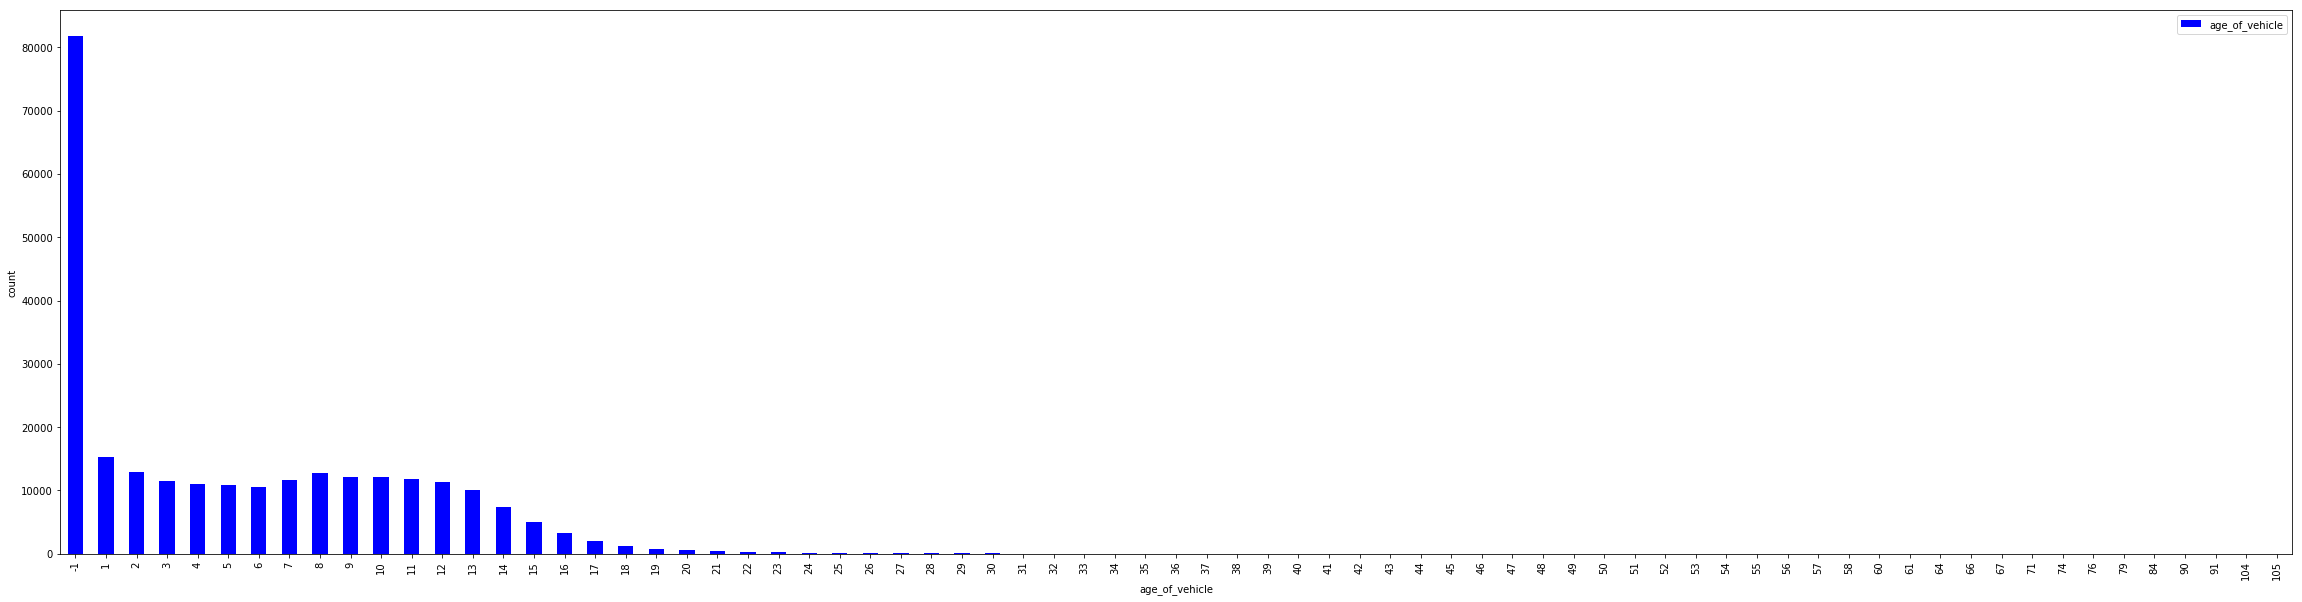

In [8]:
'''
RTA Vehicles check data fields
'''

# check data
col = 'age_of_vehicle'

plt.figure(figsize=(40,10))
Vehicles.groupby([col])[col].count().plot(kind='bar',color='b',legend=True)
plt.ylabel('count')
#plt.axis((0,30,0,17500)) #age of vehicle
#plt.axis((0,1000,0,2000)) #engine capacity TBD
#plt.axis((5,95,0,7000)) #age of driver TBD

plt.savefig('Data/Pics/Vehicle_Bar_'+col+'.png')
plt.show()